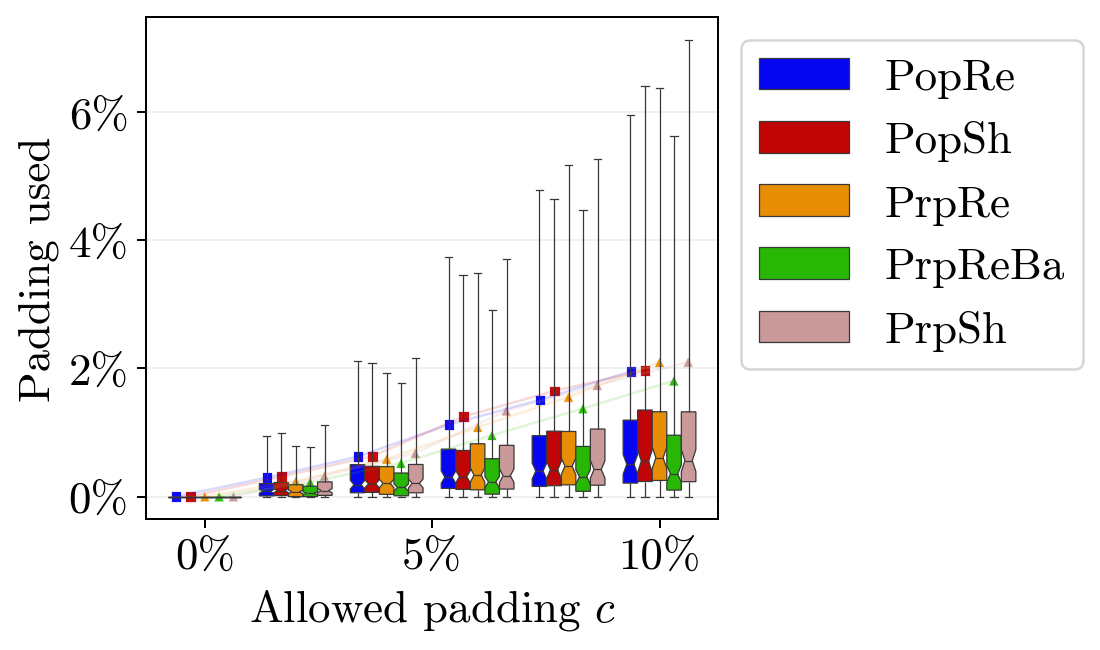

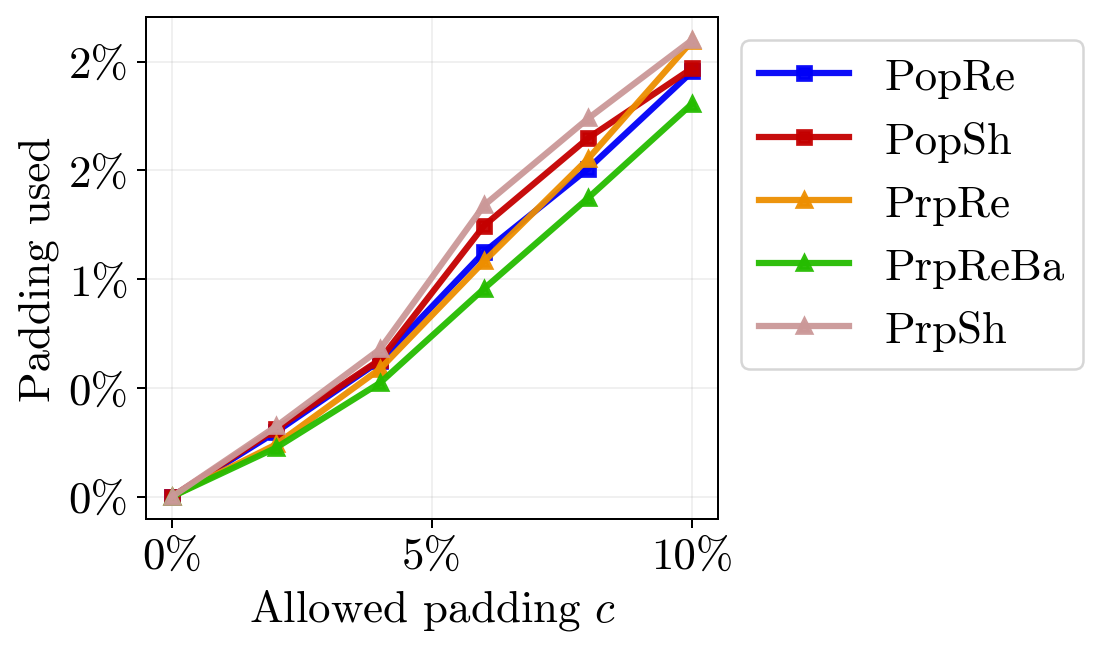

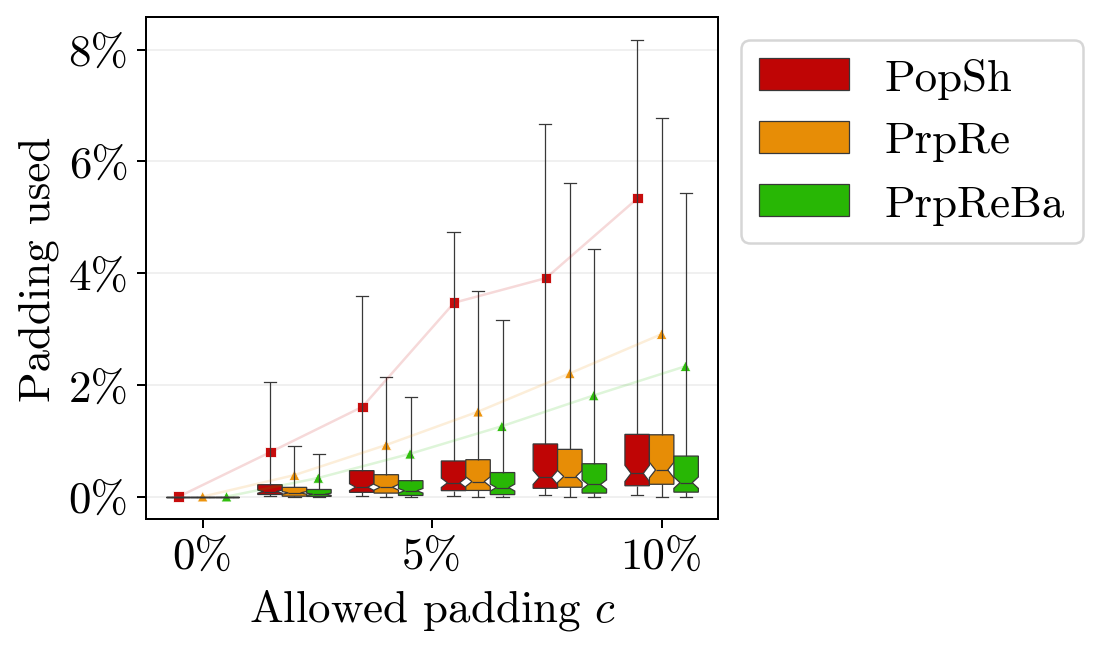

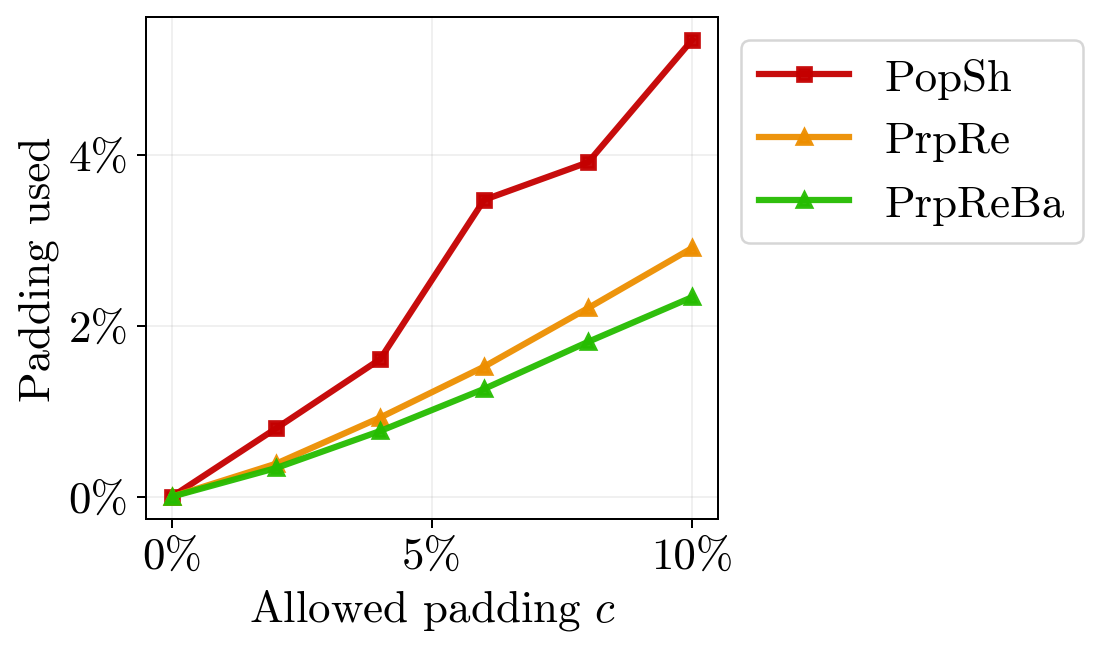

In [1]:
def context_cm_font():
    """
    Sets the default font and the math font to Computer Modern Roman without using TeX.
    """
    # https://stackoverflow.com/a/57575236/3671939
    import matplotlib.font_manager as font_manager
    import matplotlib

    path = matplotlib.get_data_path() + "/fonts/ttf/cmr10.ttf"
    cmfont = font_manager.FontProperties(fname=path)  # type: ignore
    return {
        "font.family": "serif",
        "font.serif": cmfont.get_name(),
        "mathtext.fontset": "cm",
        "axes.unicode_minus": False,
    }


from pathlib import Path
from typing import Any, cast
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import pandas as pd
import numpy as np


def load_txt(path: Path):
    return pd.DataFrame([eval(l) for l in path.read_text().strip().split("\n")])


def quantiles_to_samples(df):
    out = []
    for (name, c), X in df.groupby(by=["name", "c"]):
        X = dict(X.iloc[0])
        q = [X[f"bandwidth_{s}"] for s in "05 25 50 75 95".split()]
        q = np.ravel([q] * 20)
        for x in q:
            out.append({"name": name, "c": c, "bandwidth_sample": x})
    return pd.DataFrame(out)


custom_palette = {
    "PopRe": "#0000F8",
    "PopSh": "#C40000",
    "PrpRe": "#ED8E00",
    "PrpReBa": "#25BC00",
    "PrpSh": "#CB9898",
}
custom_markers = {
    "PopRe": "s",
    "PopSh": "s",
    "PrpRe": "^",
    "PrpReBa": "^",
    "PrpSh": "^",
}

cwd = Path("./").absolute()
df_list = [
    load_txt(cwd / "__exec_files" / "1000-all.py.txt").sort_values(by=["name"]),
    load_txt(cwd / "__exec_files" / "423450-december.txt").sort_values(by=["name"]),
]

for df in df_list:
    df = df[df["name"] != "PopReSh"]
    df = df[df["name"] != "PopReBa"]

    with plt.rc_context({**context_cm_font(), "font.size": 18}):
        fig, ax = plt.subplots(figsize=(6, 3.5), dpi=180, layout="constrained")

        ax.yaxis.set_major_formatter(FuncFormatter(lambda y, pos: f"{round(y * 100)}%"))
        ax.xaxis.set_major_formatter(
            FuncFormatter(lambda x, pos: f"{round((x-1) * 100)}%")
        )

        sns.boxplot(
            x="c",
            y="bandwidth_sample",
            hue="name",
            data=quantiles_to_samples(df),
            order=None,
            hue_order=None,
            orient=None,
            color=None,
            palette=cast(Any, custom_palette),
            native_scale=True,
            saturation=0.95,
            width=0.8,
            notch=True,
            dodge=True,
            linewidth=0.5,
            whis=cast(Any, (5, 95)),
            ax=ax,
        )
        k = len(np.unique(df["name"]))
        shifts = 0.0063 * np.linspace(-1, 1, k)
        if k == 3:
            shifts = 0.0052 * np.linspace(-1, 1, k)
        for (name, sub), shift in zip(df.groupby(by="name"), shifts):
            sub = sub.copy()
            sub["c"] += shift
            marker = custom_markers[cast(Any, name)]
            sns.scatterplot(
                data=sub,
                x="c",
                y="bandwidth",
                hue="name",
                ax=ax,
                palette=cast(Any, custom_palette),
                size=2.5 if marker == "s" else 3.5,
                # markers=[custom_markers[cast(Any, name)]],
                marker=marker,
                alpha=0.95,
                legend=False,
            )
            sns.lineplot(
                data=sub,
                x="c",
                y="bandwidth",
                hue="name",
                ax=ax,
                palette=cast(Any, custom_palette),
                lw=1,
                alpha=0.15,
                legend=False,
            )
        plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
        plt.grid(lw=0.15, axis="y")
        ax.set_ylabel("Padding used")
        ax.set_xlabel("Allowed padding $c$")
        plt.show()

        fig, ax = plt.subplots(figsize=(6, 3.5), dpi=180, layout="constrained")

        ax.yaxis.set_major_formatter(FuncFormatter(lambda y, pos: f"{round(y * 100)}%"))
        ax.xaxis.set_major_formatter(
            FuncFormatter(lambda x, pos: f"{round((x-1) * 100)}%")
        )
        sns.pointplot(
            data=df,
            x="c",
            y="bandwidth",
            hue="name",
            ax=ax,
            palette=cast(Any, custom_palette),
            markersize=5,
            markers=[custom_markers[s] for s in df["name"].unique()],
            alpha=0.95,
            lw=2.5,
            native_scale=True,
        )
        plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
        plt.grid(lw=0.15, which="major")
        ax.set_ylabel("Padding used")
        ax.set_xlabel("Allowed padding $c$")
        plt.show()